In [189]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [190]:
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set("".join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i+1: s for i,s in enumerate(chars)}
itos[0] = '.'

In [191]:
# build the dataset
block_size = 3 # context length
def build_dataset(words):
    X, Y = [], []
    
    for word in words:
        #print(word)
        context = [0] * block_size
        for ch in word + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print("".join(itos[i] for i in context), '-->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [54]:
g = torch.Generator().manual_seed(2147483647)
n_embed = 10
n_hidden = 100
n_vocab = len(stoi)
C = torch.randn((n_vocab, n_embed),                  generator=g)
W1 = torch.randn(( n_embed*block_size, n_hidden),    generator=g) * ((5/3) / ((n_embed*block_size) ** 0.5)) # kaiming init
#b1 = torch.randn(n_hidden,                           generator=g) * 0.01
W2 = torch.randn((n_hidden,n_vocab),                 generator=g) * 0.01
b2 = torch.randn(n_vocab,                            generator=g) * 0
bnormgain = torch.ones((1, n_hidden)) # Batch norm gain
bnormbias = torch.zeros((1, n_hidden)) # Batch norm bias

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))
params = [C, W1, W2, b2, bnormgain, bnormbias]
for p in params:
    p.requires_grad = True

In [35]:
max_steps = 200000
batch_size = 32
for i in range(max_steps):
    #mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batches

    # Forward Pass
    emb = C[Xb] # embedding
    embcat = emb.view(emb.shape[0], -1) # concatenate the inputs

    # Linear Layer
    hpreact = embcat @ W1  #+ b1 # h before activation function, don't need bias with batch norm

    # BatchNorm Layer
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True) 
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
        
    hpreact = bnormgain * (hpreact -bnmeani )/bnstdi + bnormbias # Batch norm

    # Non-linearity
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # Backward pass
    for p in params:
        p.grad = None
    loss.backward()
    lr = 0.1 if i < 100000 else 0.01
    for p in params:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i} / {max_steps}: {loss.item():.4f}')

0 / 200000: 3.3068
10000 / 200000: 2.6448
20000 / 200000: 2.3918
30000 / 200000: 2.3871
40000 / 200000: 2.1753
50000 / 200000: 1.8566
60000 / 200000: 1.8130
70000 / 200000: 2.2426
80000 / 200000: 2.2061
90000 / 200000: 2.1235
100000 / 200000: 2.1020
110000 / 200000: 2.5965
120000 / 200000: 2.1147
130000 / 200000: 1.9578
140000 / 200000: 2.2512
150000 / 200000: 1.9054
160000 / 200000: 2.3440
170000 / 200000: 2.1494
180000 / 200000: 2.1625
190000 / 200000: 1.9574


In [19]:
# Calibrate the batch norm mean and std after training
with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean and std of the batch (training set)
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)
# but really we want to keep track of this during training

In [27]:
bnstd

tensor([[2.3812, 2.0383, 2.1732, 2.2229, 2.2598, 2.2340, 2.2698, 2.3249, 2.2406,
         2.1181, 2.5885, 2.1888, 2.0372, 2.1467, 2.0165, 2.7019, 2.4761, 1.7406,
         2.2387, 2.6876, 2.2307, 2.2744, 2.0860, 2.2086, 2.1595, 1.7752, 2.1354,
         2.3874, 2.4919, 2.3985, 1.6526, 2.0617, 2.1455, 1.9279, 1.8736, 1.9116,
         2.5898, 2.3461, 1.6627, 1.7553, 2.1118, 1.8270, 2.3932, 1.9128, 2.3402,
         2.3957, 2.2254, 2.6931, 2.0383, 2.4374, 2.1513, 1.8430, 1.8877, 1.8855,
         2.1556, 2.2739, 2.1369, 2.2370, 2.3509, 1.8304, 1.9239, 2.1622, 1.9543,
         2.3262, 2.1607, 2.2537, 2.0735, 2.3460, 2.0761, 2.0637, 2.0347, 1.9130,
         2.1704, 1.8924, 1.8782, 1.9687, 2.3392, 2.1348, 2.0427, 2.3412, 2.2135,
         1.6714, 2.1131, 2.1544, 2.2694, 2.2039, 2.1356, 2.2939, 2.4402, 2.6746,
         1.9763, 1.8345, 2.2495, 2.0040, 2.1190, 2.0772, 2.0007, 1.8589, 2.3475,
         2.0364, 2.5694, 1.8684, 2.2924, 2.2758, 2.0271, 2.2731, 1.9167, 2.0854,
         1.9200, 2.0116, 2.3

In [26]:
bnstd_running # pretty much the same as the std calculated after training

tensor([[2.3603, 2.0241, 2.1528, 2.1951, 2.2426, 2.2161, 2.2492, 2.3061, 2.2224,
         2.0926, 2.5575, 2.1613, 2.0099, 2.1327, 1.9979, 2.6658, 2.4543, 1.7214,
         2.2128, 2.6861, 2.2069, 2.2489, 2.0630, 2.1951, 2.1366, 1.7768, 2.1116,
         2.3740, 2.4581, 2.3723, 1.6375, 2.0345, 2.1239, 1.9175, 1.8500, 1.8940,
         2.5659, 2.3290, 1.6462, 1.7327, 2.0877, 1.8121, 2.3817, 1.9040, 2.3147,
         2.3778, 2.1981, 2.6437, 2.0182, 2.4213, 2.1260, 1.8226, 1.8716, 1.8555,
         2.1347, 2.2573, 2.1169, 2.2180, 2.3225, 1.8091, 1.8998, 2.1426, 1.9380,
         2.3094, 2.1364, 2.2333, 2.0601, 2.3328, 2.0525, 2.0450, 2.0151, 1.8936,
         2.1518, 1.8671, 1.8584, 1.9506, 2.3232, 2.1230, 2.0167, 2.3170, 2.1873,
         1.6553, 2.0980, 2.1355, 2.2564, 2.1832, 2.1094, 2.2617, 2.4277, 2.6456,
         1.9505, 1.8046, 2.2250, 1.9808, 2.1090, 2.0725, 1.9735, 1.8476, 2.3363,
         2.0156, 2.5484, 1.8496, 2.2699, 2.2553, 2.0090, 2.2539, 1.8851, 2.0652,
         1.9021, 1.9904, 2.3

In [15]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xtest, Ytest)
    }[split]
    emb = C[x] # embedding
    embcat = emb.view(emb.shape[0], -1) # concatenate the inputs
    hpreact = embcat @ W1 + b1 # h before activation function
    hpreact = bnormgain * (hpreact -bnmean)/bnstd + bnormbias # Batch norm
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
split_loss('train')
split_loss('dev')

train 2.0652761459350586
dev 2.107738733291626


loss log

original: 
    train 2.1124
    dev 2.1642

fix softmax layer being confidently wrong -> initializing probabilities that aren't equal. Probabilities should be near equal at the start of training since the network doesn't know anything yet. (W2 * 0.01, b2 * 0)

    train 2.0676605701446533

    dev 2.150639057159424
    
fix tanh layer too saturated at init  (W1 * 0.2, b1 * 0.01), Also get the same when using the Kaiming init on the fan_in
    
    train 2.0328710079193115
    
    dev 2.120044708251953

add batch norm layer (not expecting an improvement since our network is so simple)

    train 2.064499855041504
    
    dev 2.1097702980041504

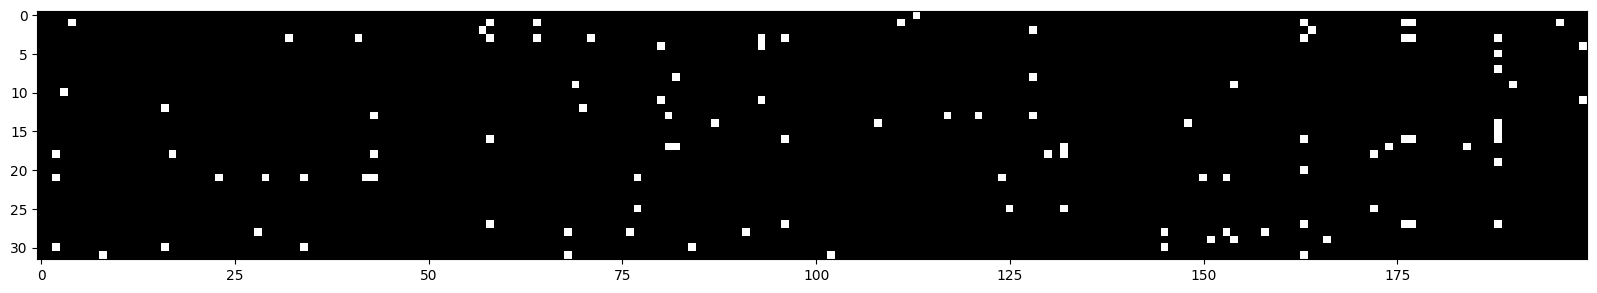

In [22]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99,cmap='grey', interpolation='nearest')
# White shows all the examples where the gradient will be ignored (set to zero with tanh)
# If a column is all white, then the neuron is dead and will never learn

In [23]:
(h.abs() > 0.99).sum(dim=0)

tensor([0, 0, 3, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 1, 3, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 1, 1, 1,
        0, 0, 0, 0, 1, 2, 0, 0, 2, 2, 2, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 3, 0, 0,
        3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 1, 1, 0, 0, 3, 0, 1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 2, 0, 0, 1, 0, 1, 1, 0, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 6, 1, 0, 1, 0,
        0, 0, 0, 0, 2, 0, 1, 0, 4, 4, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 8, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 2])

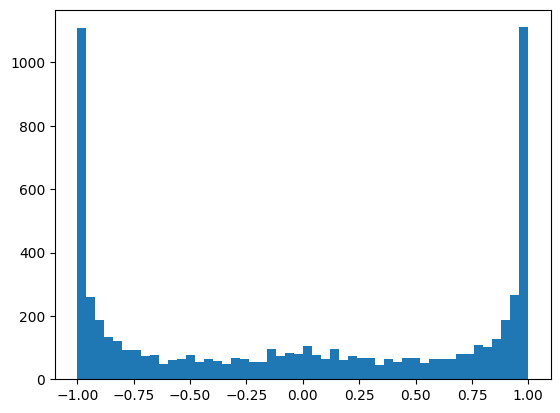

In [6]:
# Check the hidden layers after tanh
# This was run when W1 and b1 were random
plt.hist(h.view(-1).tolist(), 50);
# This is bad because when we back propagate through tanh we do '(1 - t**2) * other.grad' where t is the output of tanh
# So if the values are close to 1 or -1, then the grad becomes zero (1 - 1**2) == 0

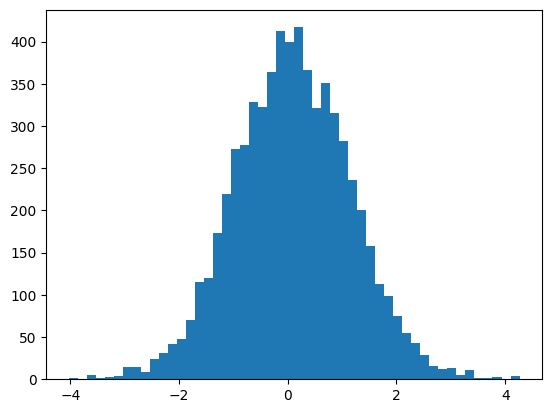

In [25]:
plt.hist(hpreact.view(-1).tolist(), 50);

In [35]:
# Sample from network
g = torch.Generator().manual_seed(2147483647)

for i in range(50):
    context = [0] * block_size
    out = ''
    ix=0
    while True:
        # Forward pass
        xenc = C[context].view((-1, c_size*block_size))
        h = torch.tanh(xenc @ W1 + b1)
        logits = h @ W2 + b2
        p =F.softmax(logits, dim=1)
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out += itos[ix]
        context = context[1:] + [ix]
        if(ix == 0):
            break
    print(out)

junide.
jakarie.
presayon.
bra.
jiir.
tolara.
juetz.
dameia.
yamilena.
jedeyaine.
imilas.
jainayla.
terinvellerif.
demil.
ponish.
jarsand.
cora.
yarion.
kaesaliya.
jamiii.
wyn.
neviansh.
safironselhaddor.
matta.
klus.
jaila.
than.
jayreli.
isa.
dyli.
mjenny.
mahadestin.
khylara.
rayder.
adarta.
malyn.
bel.
hugi.
lavarocklyhamielyn.
aven.
madly.
tavishtikiasaiah.
marlen.
brafabubreer.
anterria.
kelizaodhid.
den.
jianiya.
rah.
ettaralylia.


### Summary 
#### Lets torchify the code

In [335]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / (fan_in ** 0.5)
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out =  x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # learnable params
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # Forward pass
        if self.training:
            x_mean = x.mean(0, keepdim=True)
            x_var = x.var(0, keepdim=True)
        else:
            x_mean = self.running_mean
            x_var = self.running_var
        # normalize
        x_hat = (x - x_mean)/torch.sqrt(x_var + self.eps)
        self.out = self.gamma * x_hat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x_var
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

n_embd = 10 # the dimensionality of the characted embedding vectors
n_hidden = 100 # hidden layers
g = torch.Generator().manual_seed(2147483647) # for reproducibility
vocab_size = len(stoi)

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False),BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False),BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False),BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
 # layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [327]:
vocab_size

27

In [336]:
# Same training as before
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
   layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()+1e-5).log10().item() for p in parameters])
  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.62%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.47%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.16%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.81%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.78%


Text(0.5, 1.0, 'activation distribution')

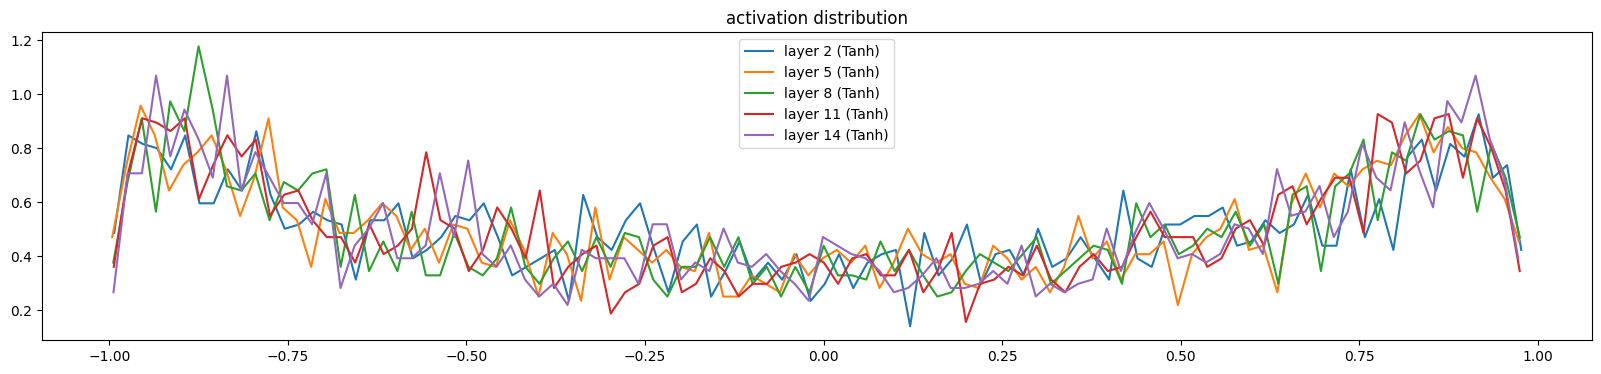

In [337]:
# visualize histogramsm outputs of the tanh layers
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 3.682951e-03
layer 5 (      Tanh): mean +0.000000, std 3.262607e-03
layer 8 (      Tanh): mean +0.000000, std 2.973728e-03
layer 11 (      Tanh): mean -0.000000, std 2.741109e-03
layer 14 (      Tanh): mean -0.000000, std 2.584293e-03


Text(0.5, 1.0, 'gradient distribution')

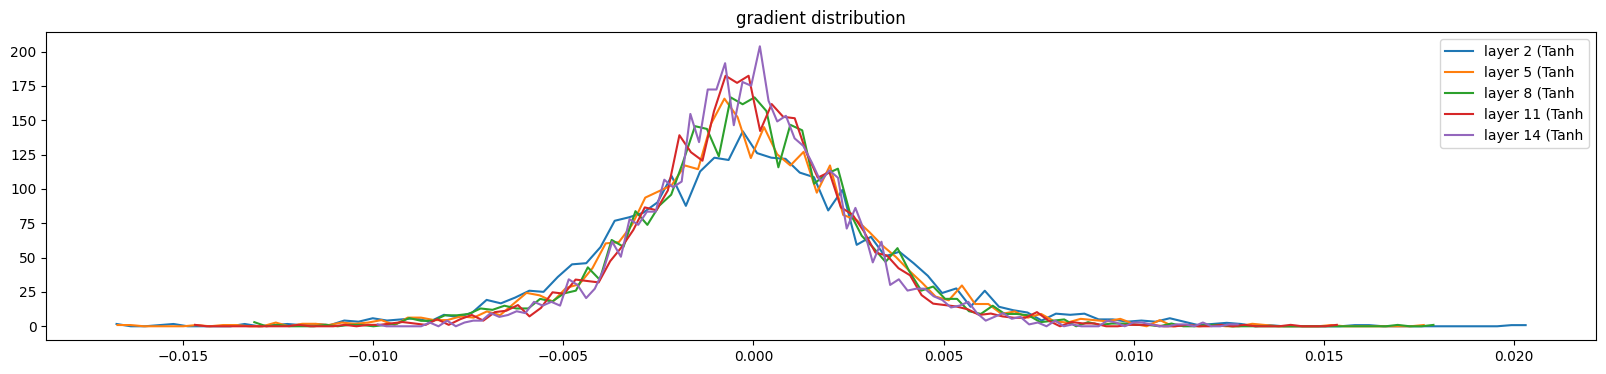

In [338]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

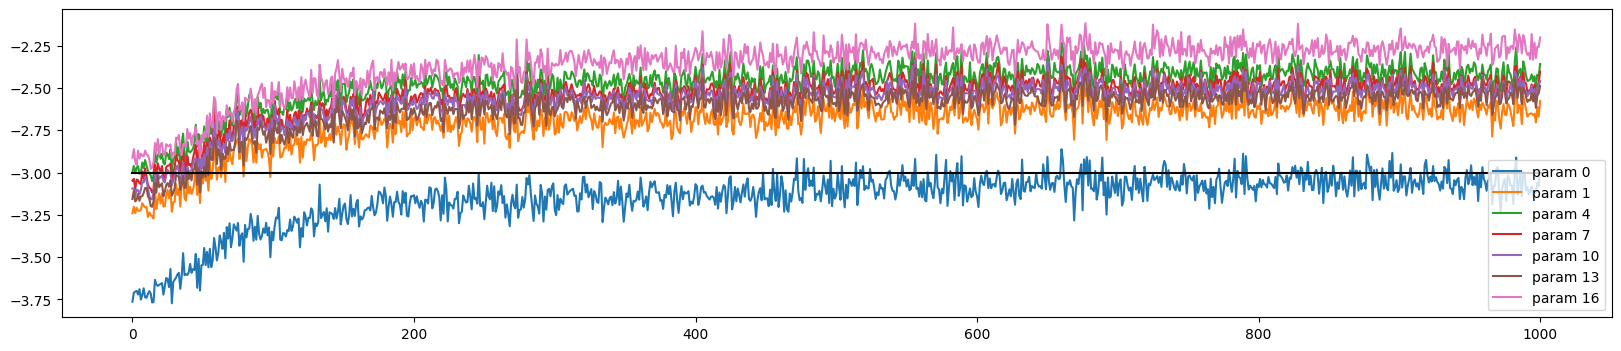

In [339]:
# Gradient std / data std. Give an idea of the size of the updates compared to the data. Should be around 1e-10. The scale is log10
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [334]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xtest, Ytest),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.823394536972046
val 2.8217897415161133


In [324]:
# sample from the modal
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:x = layers[0]
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1, block_size, n_embed)
        x = emb.view(emb.shape[0], -1) # (1, block_size*n_embed)
        x = layers[0](x)
        x = layers[-2](x)
        x = layers[-1](x)
        logits = x
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out)) # decord and print generated word
        

eriaaimyaahreelmnd.
ryal.
rethrsjejdrleg.
adeeedieliihemi.
realeieiseananarneltzimhlkaa.
n.
sadbvrgahimies.
.
n.
ir.
eelklxnteuofku.
amnedar.
yihle.
ehs.
laajhysknyaa.
hia.
nalyaisun.
zajelveuren.
.
.


In [319]:
# Exercises
# Exercises:
# - E01: I did not get around to seeing what happens when you initialize all weights and biases to zero. Try this and train the neural net. You might think either that 1) the network trains just fine or 2) the network doesn't train at all, but actually it is 3) the network trains but only partially, and achieves a pretty bad final performance. Inspect the gradients and activations to figure out what is happening and why the network is only partially training, and what part is being trained exactly.
# - E02: BatchNorm, unlike other normalization layers like LayerNorm/GroupNorm etc. has the big advantage that after training, the batchnorm gamma/beta can be "folded into" the weights of the preceeding Linear layers, effectively erasing the need to forward it at test time. Set up a small 3-layer MLP with batchnorms, train the network, then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b by creating a new W2, b2 and erasing the batch norm. Verify that this gives the same forward pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.


In [321]:
# E01 - With zero initialization of weights then only the last layers ever gets trained. This is because the gradients become zero and no learning is done.
# When doing the validation and skipping all the middle layers, only using the first, second last and last layer then the validation is the same 
# as using all the layers

In [340]:
# Small 3 layer network with back prop
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / (fan_in ** 0.5)
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out =  x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # learnable params
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # Forward pass
        if self.training:
            x_mean = x.mean(0, keepdim=True)
            x_var = x.var(0, keepdim=True)
        else:
            x_mean = self.running_mean
            x_var = self.running_var
        # normalize
        x_hat = (x - x_mean)/torch.sqrt(x_var + self.eps)
        self.out = self.gamma * x_hat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x_var
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []
n_embd = 10 # the dimensionality of the characted embedding vectors
n_hidden = 100 # hidden layers
g = torch.Generator().manual_seed(2147483647) # for reproducibility
vocab_size = len(stoi)

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False),BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False),BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
 # layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

16424


In [341]:
# Same training as before
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
   layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()+1e-5).log10().item() for p in parameters])
  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.3138


In [448]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xtest, Ytest),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.4865777492523193
val 2.481955051422119


In [343]:
layers

In [516]:
def fold(x, linear, batchNorm):
    bn_var_rsqrt = torch.rsqrt(batchNorm.running_var + batchNorm.eps)
    w_fold = linear.weight * (batchNorm.gamma * bn_var_rsqrt)
    b = linear.bias
    if b is None:
        b = torch.zeros(batchNorm.running_mean.shape)
    b_fold = (b - batchNorm.running_mean) * bn_var_rsqrt * batchNorm.gamma + batchNorm.beta
    return  x @ w_fold + b_fold 

In [517]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xtest, Ytest),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for i in range(1, len(layers)):
        if isinstance(layers[i-1], Linear) and isinstance(layers[i], BatchNorm1d):
            x = fold(x, layers[i-1], layers[i])
        elif isinstance(layers[i], Tanh):
            x = layers[i](x)    
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.4865777492523193
val 2.48195481300354
